In [1]:
%matplotlib inline
import os
os.environ["CGT_COMPAT_MODE"] = "theano"
os.environ["THEANO_FLAGS"] = "device=cpu"
import matplotlib.pyplot as plt
from mdp import HopperMDP
from policy import MujocoPolicy
from algo.ppo import explained_variance_1d
import numpy as np
import sys

mdp = HopperMDP()
policy = MujocoPolicy(mdp)

Couldn't import dot_parser, loading of dot files will not be possible.
Using Theano for CGT compatibility mode


In [2]:
import os
data_paths = sorted([path for path in os.listdir("data/hopper_100k_newpaths") if path.endswith("npz")])
data_paths = ["data/hopper_100k_newpaths/%s" % path for path in data_paths]

In [3]:
data = np.load(data_paths[0])

In [4]:
paths = data["paths"]

In [5]:
print paths[0].keys()
print len(paths)

['rewards', 'pdists', 'advantage', 'actions', 'states', 'returns', 'observations']
4960


In [6]:
# We can recover the standard normal random numbers from pdists and actions
pdists = np.concatenate([path['pdists'] for path in paths])
means, logstds = policy._split_pdist(pdists)
actions = np.concatenate([path['actions'] for path in paths])

(array([   312.,   3144.,  16880.,  53944.,  90208.,  83840.,  39648.,
         10360.,   1512.,    152.]),
 array([-3.91162068, -3.1027487 , -2.29387672, -1.48500475, -0.67613277,
         0.13273921,  0.94161119,  1.75048317,  2.55935515,  3.36822713,
         4.1770991 ]),
 <a list of 10 Patch objects>)

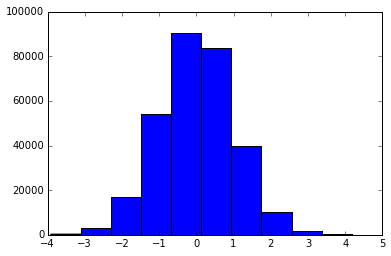

In [7]:
# This should follow the normal distribution
srand = (actions - means) / np.exp(logstds)
plt.hist(srand.reshape(-1))

In [8]:
srand.shape

(100000, 3)

In [9]:
paths_list = []
for path in data_paths[:50]:
    print "loading %s" % path
    paths_list.append(np.load(path)["paths"])

loading data/hopper_100k_newpaths/itr_000.npz
loading data/hopper_100k_newpaths/itr_001.npz
loading data/hopper_100k_newpaths/itr_002.npz
loading data/hopper_100k_newpaths/itr_003.npz
loading data/hopper_100k_newpaths/itr_004.npz
loading data/hopper_100k_newpaths/itr_005.npz
loading data/hopper_100k_newpaths/itr_006.npz
loading data/hopper_100k_newpaths/itr_007.npz
loading data/hopper_100k_newpaths/itr_008.npz
loading data/hopper_100k_newpaths/itr_009.npz
loading data/hopper_100k_newpaths/itr_010.npz
loading data/hopper_100k_newpaths/itr_011.npz
loading data/hopper_100k_newpaths/itr_012.npz
loading data/hopper_100k_newpaths/itr_013.npz
loading data/hopper_100k_newpaths/itr_014.npz
loading data/hopper_100k_newpaths/itr_015.npz
loading data/hopper_100k_newpaths/itr_016.npz
loading data/hopper_100k_newpaths/itr_017.npz
loading data/hopper_100k_newpaths/itr_018.npz
loading data/hopper_100k_newpaths/itr_019.npz
loading data/hopper_100k_newpaths/itr_020.npz
loading data/hopper_100k_newpaths/

In [12]:
print len(paths_list)

50


In [24]:
# Let's first reproduce the fitness of the linear value function

class HopperValueFunction(object):

    def __init__(self):
        self.coeffs = None

    def get_param_values(self):
        return self.coeffs

    def set_param_values(self, val):
        self.coeffs = val

    def _features(self, path):
        o = np.clip(path["observations"], -10,10)
        l = len(path["rewards"])
        al = np.arange(l).reshape(-1,1)/100.0
        return np.concatenate([o, o**2, al, al**2, al**3, np.ones((l, 1))], axis=1)

    def fit(self, paths):
        featmat = np.concatenate([self._features(path) for path in paths])
        returns = np.concatenate([path["returns"] for path in paths])
        self.coeffs = np.linalg.lstsq(featmat, returns)[0]

    def predict(self, path):
        if self.coeffs is None:
            return np.zeros(len(path["rewards"]))
        return self._features(path).dot(self.coeffs)

vf = HopperValueFunction()
next_evs = []
cur_evs = []
for paths, next_paths in zip(paths_list, paths_list[1:]):
    vf.fit(paths)
    predicted_next_returns = np.concatenate([vf.predict(path) for path in next_paths])
    predicted_cur_returns = np.concatenate([vf.predict(path) for path in paths])
    true_next_returns = np.concatenate([path["returns"] for path in next_paths])
    true_cur_returns = np.concatenate([path["returns"] for path in paths])
    next_ev = explained_variance_1d(predicted_next_returns, true_next_returns)
    cur_ev = explained_variance_1d(predicted_cur_returns, true_cur_returns)
    next_evs.append(next_ev)
    cur_evs.append(cur_ev)
    print cur_ev, next_ev
    sys.stdout.flush()

0.421962142521 0.244706598344
0.360667912829 0.120763397878
0.289638633145 0.160594980026
0.27077694004 0.166588597965
0.22752852682 0.176602367723
0.246658198219 0.362929263089
0.426039180435 0.553272075439
0.590730245702 0.623942052083
0.675543883111 0.677862235725
0.707499894413 0.755123025117
0.776039793721 0.820182684747
0.832472728987 0.804206674417
0.826774897886 0.842465915988
0.851810185109 0.835121137846
0.843799512615 0.890419213413
0.900166800218 0.806632894598
0.843664657932 0.714728097629
0.732092833743 0.714565724243
0.742243216154 0.67935390236
0.699610649597 0.763108193442
0.779801099094 0.423415750173
0.644723882412 0.778582602509
0.820535659904 0.721339282493
0.78026133156 0.721089538593
0.757093548501 0.818538667803
0.842574135026 0.757854814802
0.767110349965 0.718291580542
0.728072033011 0.625950756093
0.645331846733 0.772932467997
0.803468291245 0.349509539423
0.465397216807 0.656246019933
0.736680995752 0.703517243519
0.745628327391 0.664153390793
0.708483037878

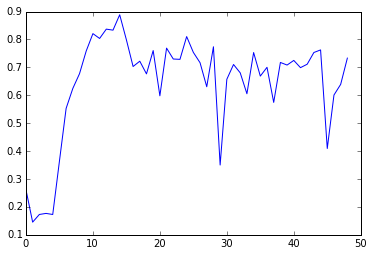

In [21]:
plt.plot(evs)

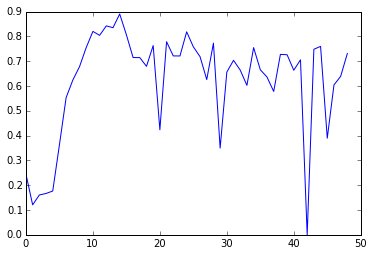

In [27]:
plt.plot(np.maximum(0, next_evs))

In TRPO, we are optimizing the following surrogate objective:

$$ E\left[\frac{\pi_\theta(a|s)}{\pi_{old}(a|s)} (Q^{\pi_{old}} (s, a) - b(s))\right]$$

where $b$ is a baseline. For stochastic policy, the variance in the gradient estimate can be due to the stochastic transition $(s, a) \mapsto s'$, the stochasticity in the reward function $r(s, a)$, or due to the stochasticity of the policy $\pi(a\mid s)$. Note that very often, we can use the reparameterization trick to rewrite the policy as a deterministic function $a = \pi(\omega, s)$, where $\omega \sim \mathcal{N}(0, 1)$. Note that the $\omega$s does not depend on future state, and we can include them in the baseline estimate:

$$ b = b(s_t, \omega_t, \ldots, \omega_T) $$

For now we can try to train a linear predictor $b = f_s(s_t) + f_t(\omega_t) + \ldots + f_T(\omega_T)$.